# 2D Biharmonic equation

We now consider the (inhomogeneous) biharmonic equation on the unit square $\Omega := (0,1) \times (0,1)$, with homogeneous essential boundary conditions on all sides.
Given a function $f \colon \Omega \to \mathbb{R}$, we search for a solution $\phi \colon \Omega \to \mathbb{R}$ that satisfies

\begin{equation}
\label{eq:BiharmonicEx_Dir_Strong}
\left\{
\begin{aligned}
        \nabla^4 \phi &= f  && \text{in $\Omega$}, \\
                    \phi &= 0  && \text{on $\partial\Omega$}, \\
     \nabla \phi \cdot \mathbf{n} &= 0  && \text{on $\partial\Omega$},
\end{aligned}
\right.
\end{equation}
where $\mathbf{n}$ is the unit vector normal to the boundary, pointing outwards.

If we let $f \in L^2(\Omega)$ and choose $H^2_0(\Omega)$ for the trial and test spaces, the weak formulation of reads:

\begin{equation}
\label{eq:BiharmonicEx_Dir_Weak}
        \text{Find $\phi \in H^2_0(\Omega)$ s.t.}
\quad
        \int_{\Omega} \nabla^2\phi\, \nabla^2\psi ~d\Omega = \int_{\Omega} f \psi ~d\Omega
\quad
        \forall \psi \in H^2_0(\Omega).
\end{equation}

For testing purposes we choose a manufactured solution $\phi$ that vanishes at the boundary, and whose gradient also vanishes:

\begin{equation}
\begin{split}
        \phi(x,y) &:= \sin^2(\pi x) \sin^2(\pi y), \\
           f(x,y) &:= \pi^{4} \left(64 \sin^{2}{\left (\pi x \right )} \sin^{2}{\left (\pi y \right )}
                     - 24 \sin^{2}{\left (\pi x \right )} - 24 \sin^{2}{\left (\pi y \right )} + 8\right).
\end{split}
\end{equation}

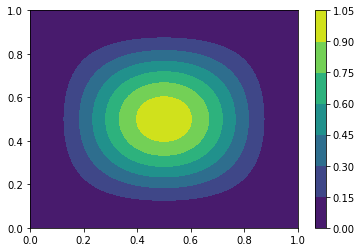

In [12]:
# Exact solution
import numpy as np
u = lambda x,y: (np.sin(np.pi*x)*np.sin(np.pi*y))**2

ts = np.linspace(0., 1., 401)
x,y = np.meshgrid(ts,ts)
contourf(x,y, u(x,y)); colorbar() ; show()

### Abstract Model

In [1]:
from sympy  import sin, pi

from sympde.calculus import laplace, dot, grad
from sympde.topology import Square, NormalVector
from sympde.topology import ScalarFunctionSpace, element_of
from sympde.expr     import integral, BilinearForm, LinearForm
from sympde.expr     import EssentialBC, find, Norm

from psydac.api.discretization import discretize

In [18]:
# Define topological domain
Omega = Square()

# Method of manufactured solutions: define exact
# solution phi_e, then compute right-hand side f
x, y  = Omega.coordinates
phi_e = (sin(pi*x)*sin(pi*y))**2
f     = laplace(laplace(phi_e))

# Define abstract model
V = ScalarFunctionSpace('V', Omega)
v = element_of(V, name='v')
u = element_of(V, name='u')

a = BilinearForm((u,v), integral(Omega, laplace(v) * laplace(u)))
l =   LinearForm(   v , integral(Omega, f * v))

nn = NormalVector('nn')
bc = [EssentialBC(               u, 0, Omega.boundary),
      EssentialBC(dot(grad(u), nn), 0, Omega.boundary)]

equation = find(u, forall=v, lhs=a(u,v), rhs=l(v), bc=bc)

# Define (abstract) error norms
phi    = element_of(V, name='phi')
error  = phi - phi_e
l2norm = Norm(error, Omega, kind='l2')
h1norm = Norm(error, Omega, kind='h1')
h2norm = Norm(error, Omega, kind='h2')

### Discretization

In [24]:
degree = [3,3]
ncells = [16,16]

In [25]:
# Create computational domain from topological domain
Omega_h = discretize(Omega, ncells=ncells, comm=None)

# Create discrete spline space
Vh = discretize(V, Omega_h, degree=degree)

# Discretize equation
equation_h = discretize(equation, Omega_h, [Vh, Vh])

# Discretize norms
l2norm_h = discretize(l2norm, Omega_h, Vh)
h1norm_h = discretize(h1norm, Omega_h, Vh)
h2norm_h = discretize(h2norm, Omega_h, Vh)

### Solving the PDE

In [22]:
# Solve discrete equation to obtain numerical solution
phi_h = equation_h.solve()

# Compute error norms from solution field
l2_error = l2norm_h.assemble(phi=phi_h)
h1_error = h1norm_h.assemble(phi=phi_h)
h2_error = h2norm_h.assemble(phi=phi_h)

In [23]:
print('> L2-norm = ', l2_error)
print('> H2-norm = ', h1_error)
print('> H2-norm = ', h2_error)

> L2-norm =  0.3152385970932358
> H2-norm =  2.2763892151212564
> H2-norm =  18.06867041845471


### Plotting the solution

In [7]:
from matplotlib.pyplot import plot, contourf, show, colorbar
%matplotlib inline
from simplines import plot_field_2d

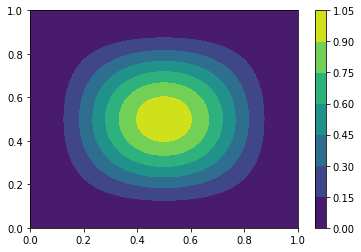

In [9]:
nbasis = [W.nbasis for W in Vh.spaces]
x = phi_h.toarray().reshape(nbasis)
plot_field_2d(Vh.knots, Vh.degree, x ); colorbar() ; show()